# Training an image segmentation model

Organise data directories containing training data.

In [ ]:
import os
import sys
import h5py  # !pip install pyyaml h5py
import time
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab import drive


# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)


# Automatically reload imported programmes
%load_ext autoreload
%autoreload 2


# Model/database choice
dataset_name = 'all-2D'  # Refers to data_file = 'tomograms2D/all'
data_file = 'tomograms2D/all'  # No leading/trailing `/`
augmentation_choice = 'full'  # Choose from 'zoom'/'full'/'none'
model_name = 'unet'  # U-Net/Autoenncoder: 'unet'/'ae'
loss_name = 'mse'  # Mean Squared Error/Sparse Cat Cross Entropy: 'mse'/'scce'
use_existing_weights = True  # If available


# Locate data and experiment
database_name = dataset_name + '-' + augmentation_choice
exp_name = model_name + '-' + database_name + '-' + loss_name


# Directories (ammend as necessary)
root_dir = '/content/gdrive/MyDrive/IDSAI/PROOF/filament-segmentation'
os.chdir(root_dir)  # Move to root_dir
sys.path.insert(0, root_dir)


# Add data to root directory and locate JSON file
data_dir = os.path.join(root_dir, 'data/' + data_file)
image_path = os.path.join(data_dir, 'png-original')
masks_path = os.path.join(data_dir, 'png-masks/semantic/*.png')


# New training and validation files
train_dir = os.path.join(root_dir, 'data/databases/' + database_name + '/train')
valid_dir = os.path.join(root_dir, 'data/databases/' + database_name + '/valid')


# Checkpoints
checkpoint_dir = os.path.join(root_dir, 'checkpoints')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
best_weights_path = os.path.join(checkpoint_dir, exp_name + '.h5')


# Figure Outputs
fig_dir = os.path.join(root_dir, 'outputs/train-' + exp_name)
os.makedirs('outputs', exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

Mounted at /content/gdrive


Choose network parameters.

In [ ]:
lr = 0.0001
epoch_freq = 10
num_epochs = 301

Assert GPU/TPU and RAM capability.

In [ ]:
%%script false
# GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
   print(gpu_info)

In [ ]:
%%script false
# TPU initialisation for tensorflow 2.X
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

In [ ]:
%%script false
## RAM availability
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Load or import data

Data choice.

In [ ]:
batch_size = 10
shuffle_on = True

if augmentation_choice == 'zoom':
    num_patches = 20  # Subsample taining data before augmenting
    num_duplicates = 1
    apply_augmentation = True

elif augmentation_choice == 'full':
    num_patches = 1
    num_duplicates = 30  # Duplicate full image to augment
    apply_augmentation = True
    
elif augmentation_choice == 'none':
    num_patches = 1
    num_duplicates = 1
    apply_augmentation = False  # No augmentation (small dataset)

else:
    raise ValueError('Please select a pre-defined `augmentation_choice`.')

Load from file or compute dataset.

In [ ]:
print('\nLoading data...')
if not os.path.exists(train_dir) and not os.path.exists(valid_dir):

    from loader import augment_data, get_data
    train_imgs, train_msks, valid_imgs, valid_msks, _, _ = \
        get_data(path_train_imgs=image_path,
                 path_train_msks=masks_path,
                 path_valid_imgs='',
                 path_valid_msks='',
                 train_frac=0.8,
                 valid_frac=0.1,
                 image_size=[256, 256],
                 num_patches_per_image=num_patches,
                 num_duplicates_per_image=num_duplicates,
                 )
        
    train_set, valid_set = augment_data(train_imgs,
                                        train_msks,
                                        valid_imgs,
                                        valid_msks,
                                        batch_size,
                                        one_hot=False,
                                        augment_on=apply_augmentation,
                                        shuffle_on=True,
                                        )

    tf.data.experimental.save(train_set, train_dir)
    tf.data.experimental.save(valid_set, valid_dir)
    print('Data processed, loaded and saved.')
else:
    train_set = tf.data.experimental.load(train_dir)
    valid_set = tf.data.experimental.load(valid_dir)
    print('Data loaded from file.')
print('\nTraining set length: ', len(train_set))
print('Validation set length: ', len(valid_set))
print('Batch size: ', batch_size)


Loading data...
Data loaded from file.

Training set length:  447
Validation set length:  56
Batch size:  10


## Load model and optimisation strategy

Define optimisation strategy.

In [ ]:
# Learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    lr, decay_steps=1000, decay_rate=0.75, staircase=True
)

# Optimiser
optimiser = keras.optimizers.Adam(learning_rate=lr_schedule)

Specify loss function and training metrics.

In [ ]:
if loss_name == 'mse':
    loss_fn = keras.losses.MeanSquaredError()
    train_metric = keras.metrics.MeanSquaredError()
    val_metric = keras.metrics.MeanSquaredError()
    num_classes = 1  # Integer class encoding

elif loss_name == 'scce':
    loss_fn = keras.losses.SparseCategoricalCrossentropy()
    train_metric = keras.metrics.SparseCategoricalAccuracy()
    val_metric = keras.metrics.SparseCategoricalAccuracy()
    num_classes = 2  # One-hot encoded classes

else:
    raise ValueError('Please select a pre-defined `loss_fn` choice.')

Instantiate model and load the `best-weights.h5` from previous training sessions.

In [ ]:
# Instantiate model
if model_name == 'unet':
    from models import get_unet_model
    model = get_unet_model(
        image_size=(256, 256), num_colour_channels=1, num_classes=num_classes,
    )

elif model_name == 'ae':
    from models import get_autoencoder_model
    model = get_autoencoder_model(
        image_size=(256, 256), num_colour_channels=1, num_classes=num_classes,
    )

else:
    raise ValueError('Please select a pre-defined `model_name` choice.')

# Call model to build and initialise weights
example_image, _ = next(iter(train_set))
model(example_image)

if os.path.exists(best_weights_path) and use_existing_weights:
    model.load_weights(best_weights_path)
    print('Model loaded with previous `best weights`.')

else:
    print('Initialising model randomly.')

model.summary()

## Training Routine

Train/test steps.

In [ ]:
@tf.function
def train_step(x, y, metric, loss_fn, opt):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss = loss_fn(y, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(grads, model.trainable_weights))
    metric.update_state(y, y_pred)  # Update training metric
    return loss

@tf.function
def test_step(x, y, loss_fn, metric=None):
    y_pred = model(x, training=False)  # Run prediction
    loss = loss_fn(y, y_pred)  # Compute loss
    if metric is not None:
        metric.update_state(y, y_pred)  # Update val metrics
    return y_pred, loss

Iterate training session.

Saving model weights at epoch 0.
Epoch 0 training loss: 0.1352

No validation loss improvement at epoch 0.
Epoch 0 validation loss: 0.0969
Epoch 0 running time: 58.47s

Training Results.
Range of mask energies: 0.043 to 0.779


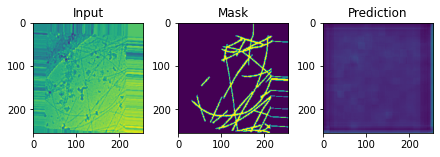


Validation Results.
Range of mask energies: 0.040 to 0.787


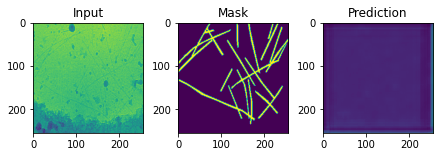



Epoch 1 training loss: 0.1021
Epoch 2 training loss: 0.0904
Epoch 3 training loss: 0.0811
Epoch 4 training loss: 0.0731
Epoch 5 training loss: 0.0677
Epoch 6 training loss: 0.0635
Epoch 7 training loss: 0.0603
Epoch 8 training loss: 0.0579
Epoch 9 training loss: 0.0559
Epoch 10 training loss: 0.0544

Validation loss decrease from 0.102 to 0.070 over epochs 0 to 10.
Saving initial model weights at epoch 10.
Epoch 10 validation loss: 0.0632
Epoch 10 running time: 38.17s

Training Results.
Range of mask energies: 0.000 to 0.999


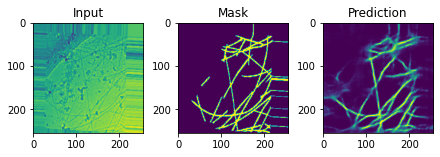


Validation Results.
Range of mask energies: 0.000 to 0.990


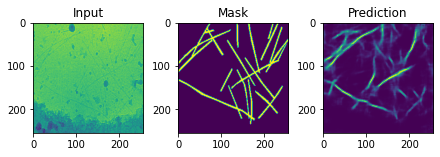



Epoch 11 training loss: 0.0530
Epoch 12 training loss: 0.0519
Epoch 13 training loss: 0.0510
Epoch 14 training loss: 0.0502
Epoch 15 training loss: 0.0495
Epoch 16 training loss: 0.0489
Epoch 17 training loss: 0.0484
Epoch 18 training loss: 0.0479
Epoch 19 training loss: 0.0476
Epoch 20 training loss: 0.0472

Validation loss decrease from 0.070 to 0.063 over epochs 10 to 20.
Saving initial model weights at epoch 20.
Epoch 20 validation loss: 0.0556
Epoch 20 running time: 38.07s

Training Results.
Range of mask energies: 0.000 to 0.999


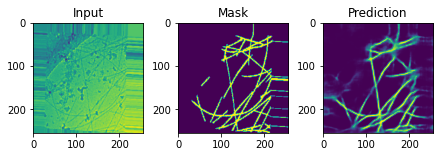


Validation Results.
Range of mask energies: 0.000 to 0.994


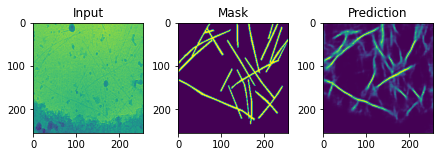



Epoch 21 training loss: 0.0469
Epoch 22 training loss: 0.0467
Epoch 23 training loss: 0.0464
Epoch 24 training loss: 0.0463
Epoch 25 training loss: 0.0461
Epoch 26 training loss: 0.0459
Epoch 27 training loss: 0.0458
Epoch 28 training loss: 0.0457
Epoch 29 training loss: 0.0456
Epoch 30 training loss: 0.0455

Validation loss decrease from 0.063 to 0.062 over epochs 20 to 30.
Saving initial model weights at epoch 30.
Epoch 30 validation loss: 0.0551
Epoch 30 running time: 37.96s

Training Results.
Range of mask energies: 0.000 to 0.999


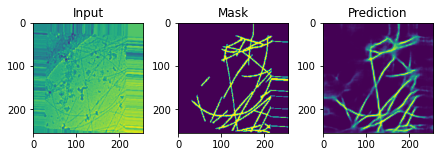


Validation Results.
Range of mask energies: 0.000 to 0.993


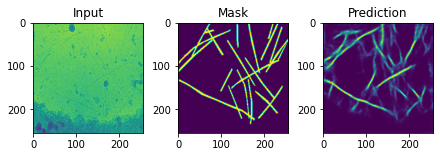



Epoch 31 training loss: 0.0454
Epoch 32 training loss: 0.0453
Epoch 33 training loss: 0.0453
Epoch 34 training loss: 0.0452
Epoch 35 training loss: 0.0452
Epoch 36 training loss: 0.0451
Epoch 37 training loss: 0.0451
Epoch 38 training loss: 0.0450
Epoch 39 training loss: 0.0450
Epoch 40 training loss: 0.0450

Validation loss decrease from 0.062 to 0.062 over epochs 30 to 40.
Saving initial model weights at epoch 40.
Epoch 40 validation loss: 0.0549
Epoch 40 running time: 38.69s

Training Results.
Range of mask energies: 0.000 to 0.999


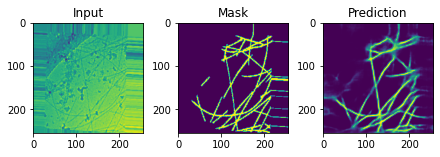


Validation Results.
Range of mask energies: 0.000 to 0.993


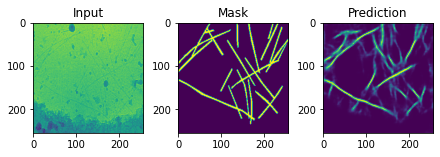



Epoch 41 training loss: 0.0450
Epoch 42 training loss: 0.0450
Epoch 43 training loss: 0.0449
Epoch 44 training loss: 0.0449
Epoch 45 training loss: 0.0449
Epoch 46 training loss: 0.0449
Epoch 47 training loss: 0.0449
Epoch 48 training loss: 0.0449
Epoch 49 training loss: 0.0449
Epoch 50 training loss: 0.0449

Validation loss decrease from 0.062 to 0.062 over epochs 40 to 50.
Saving initial model weights at epoch 50.
Epoch 50 validation loss: 0.0549
Epoch 50 running time: 38.09s

Training Results.
Range of mask energies: 0.000 to 0.999


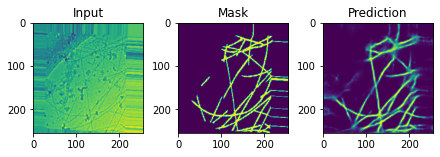


Validation Results.
Range of mask energies: 0.000 to 0.994


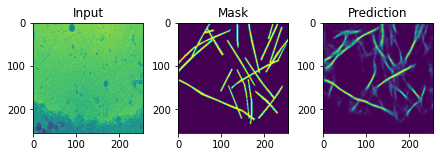



Epoch 51 training loss: 0.0449
Epoch 52 training loss: 0.0448
Epoch 53 training loss: 0.0448
Epoch 54 training loss: 0.0448
Epoch 55 training loss: 0.0448
Epoch 56 training loss: 0.0448
Epoch 57 training loss: 0.0448
Epoch 58 training loss: 0.0448
Epoch 59 training loss: 0.0448
Epoch 60 training loss: 0.0448

Validation loss decrease from 0.062 to 0.062 over epochs 50 to 60.
Saving initial model weights at epoch 60.
Epoch 60 validation loss: 0.0548
Epoch 60 running time: 38.59s

Training Results.
Range of mask energies: 0.000 to 0.999


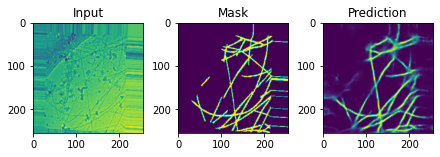


Validation Results.
Range of mask energies: 0.000 to 0.994


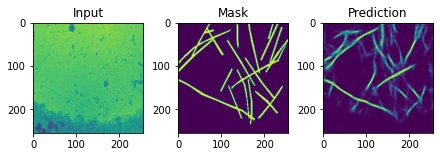



Epoch 61 training loss: 0.0448
Epoch 62 training loss: 0.0448
Epoch 63 training loss: 0.0448
Epoch 64 training loss: 0.0448
Epoch 65 training loss: 0.0448
Epoch 66 training loss: 0.0448
Epoch 67 training loss: 0.0448
Epoch 68 training loss: 0.0448
Epoch 69 training loss: 0.0448
Epoch 70 training loss: 0.0448

Validation loss decrease from 0.062 to 0.062 over epochs 60 to 70.
Saving initial model weights at epoch 70.
Epoch 70 validation loss: 0.0548
Epoch 70 running time: 38.44s

Training Results.
Range of mask energies: 0.000 to 0.999


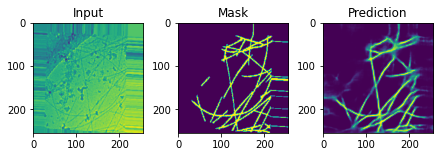


Validation Results.
Range of mask energies: 0.000 to 0.994


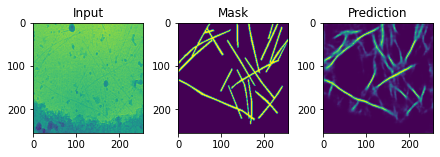



Epoch 71 training loss: 0.0448
Epoch 72 training loss: 0.0448
Epoch 73 training loss: 0.0448
Epoch 74 training loss: 0.0448
Epoch 75 training loss: 0.0448
Epoch 76 training loss: 0.0448
Epoch 77 training loss: 0.0448
Epoch 78 training loss: 0.0448
Epoch 79 training loss: 0.0448
Epoch 80 training loss: 0.0448

Validation loss decrease from 0.062 to 0.062 over epochs 70 to 80.
Saving initial model weights at epoch 80.
Epoch 80 validation loss: 0.0548
Epoch 80 running time: 38.08s

Training Results.
Range of mask energies: 0.000 to 0.999


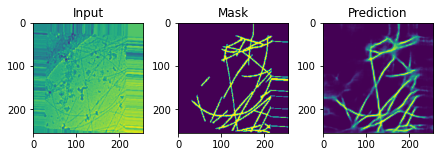


Validation Results.
Range of mask energies: 0.000 to 0.994


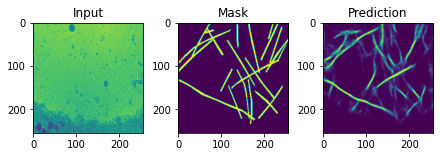



Epoch 81 training loss: 0.0448
Epoch 82 training loss: 0.0448
Epoch 83 training loss: 0.0448
Epoch 84 training loss: 0.0448
Epoch 85 training loss: 0.0448
Epoch 86 training loss: 0.0448
Epoch 87 training loss: 0.0448
Epoch 88 training loss: 0.0448
Epoch 89 training loss: 0.0448
Epoch 90 training loss: 0.0448

Validation loss decrease from 0.062 to 0.062 over epochs 80 to 90.
Saving initial model weights at epoch 90.
Epoch 90 validation loss: 0.0548
Epoch 90 running time: 38.69s

Training Results.
Range of mask energies: 0.000 to 0.999


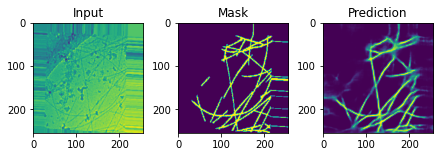


Validation Results.
Range of mask energies: 0.000 to 0.994


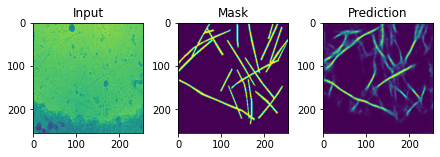



Epoch 91 training loss: 0.0448
Epoch 92 training loss: 0.0448
Epoch 93 training loss: 0.0448
Epoch 94 training loss: 0.0448
Epoch 95 training loss: 0.0448
Epoch 96 training loss: 0.0448
Epoch 97 training loss: 0.0448
Epoch 98 training loss: 0.0448
Epoch 99 training loss: 0.0448
Epoch 100 training loss: 0.0448

Validation loss decrease from 0.062 to 0.062 over epochs 90 to 100.
Saving initial model weights at epoch 100.
Epoch 100 validation loss: 0.0548
Epoch 100 running time: 38.34s

Training Results.
Range of mask energies: 0.000 to 0.999


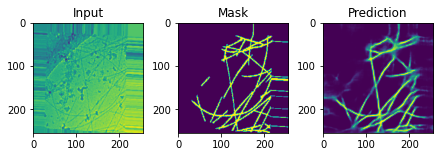


Validation Results.
Range of mask energies: 0.000 to 0.994


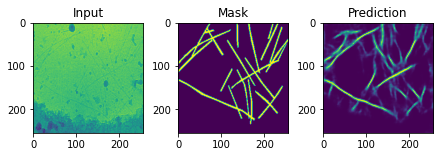



Epoch 101 training loss: 0.0448
Epoch 102 training loss: 0.0448
Epoch 103 training loss: 0.0448
Epoch 104 training loss: 0.0448
Epoch 105 training loss: 0.0448
Epoch 106 training loss: 0.0448
Epoch 107 training loss: 0.0448
Epoch 108 training loss: 0.0448


KeyboardInterrupt: ignored

In [12]:
# Iterate training session
train_losses, train_acc, val_losses, val_acc = [], [], [], []
best_epoch = 0

for epoch in range(num_epochs):
    start_time = time.time()

    if epoch == 0:
        print('Saving model weights at epoch {:d}.'.format(epoch))
        model.save_weights(best_weights_path, save_format='h5')

    # Iterate over the batches of the dataset
    for step, (x_train, y_train) in enumerate(train_set):

        # Take training step, optimising model and computing loss
        loss = train_step(x_train, y_train, train_metric, loss_fn, optimiser)
        train_losses.extend(np.array(loss).flatten())  # Store accumulation

        last_train_data = (x_train, y_train)  # Save last value for plotting


    # Display metrics at the end of each epoch
    train_acc.append(train_metric.result())
    train_metric.reset_states()
    print("Epoch {:d} training loss: {:.4f}"
          .format(epoch, float(train_acc[-1]))
    )


    # Validate and checkpoint every `epoch_freq` epochs
    if epoch % epoch_freq == 0:

        for x_val, y_val in valid_set:
            ypred_val, loss_val = test_step(x_val, y_val, loss_fn, val_metric)



        if epoch > 0 and all(loss_val <= loss for loss in val_losses):
            best_epoch = epoch
            print('\nValidation loss decrease from {:.4f} to {:.4f} '
                  'over epochs {:d} to {:d}.'.format(val_losses[-1],
                                                     loss_val,
                                                     epoch - epoch_freq,
                                                     epoch,
                                                     )
            )

            print('Saving initial model weights at epoch {:d}.'.format(epoch))
            model.save_weights(best_weights_path, save_format='h5')

        else:
            print(
                '\nNo validation loss improvement at epoch {:d}.'.format(epoch)
            )

        # Update validation metrics
        val_losses.append(loss_val)
        val_acc.append(val_metric.result())
        val_metric.reset_states()
        print("Epoch {:d} validation loss: {:.4f}"
              .format(epoch, float(val_acc[-1]))
              )
        print("Epoch {:d} running time: {:.2f}s"
              .format(epoch, time.time() - start_time)
        )

        # Training predicition for printing
        x_train, y_train = last_train_data
        ypred_train, loss_train = test_step(x_train, y_train, loss_fn)

        # Graphical Output
        print('\nTraining Results.')
        print('Range of mask energies: {min:.3f} to {max:.3f}'
            .format(min=np.min(ypred_train[0, :, :, 0]),
                    max=np.max(ypred_train[0, :, :, 0]),
                    )
            )
        fig, ax = plt.subplots(1, 3, constrained_layout=True)
        ax[0].imshow(x_train[3, :, :, 0])
        ax[0].set_title('Input')
        ax[1].imshow(y_train[3, :, :, 0])
        ax[1].set_title('Mask')
        ax[2].imshow(ypred_train[3, :, :, 0])
        ax[2].set_title('Prediction')
        plt.show()
        fig.savefig(os.path.join(fig_dir, 'train_epoch{:04d}'.format(epoch)))

        print('\nValidation Results.')
        print('Range of mask energies: {min:.3f} to {max:.3f}'
            .format(min=np.min(ypred_val[0, :, :, 0]),
                    max=np.max(ypred_val[0, :, :, 0]),
                    )
            )
        fig, ax = plt.subplots(1, 3, constrained_layout=True)
        ax[0].imshow(x_val[3, :, :, 0])
        ax[0].set_title('Input')
        ax[1].imshow(y_val[3, :, :, 0])
        ax[1].set_title('Mask')
        ax[2].imshow(ypred_val[3, :, :, 0])
        ax[2].set_title('Prediction')
        plt.show()
        fig.savefig(os.path.join(fig_dir, 'valid_epoch{:04d}'.format(epoch)))
        print('\n')

In [ ]:
# Generate loss plot
fig, ax = plt.subplots(1, 1)

xt = np.linspace(
    0, num_epochs - (1/len(train_set)), num_epochs * len(train_set)
)

xv = np.linspace(0, num_epochs - epoch_freq, int(num_epochs / epoch_freq))

ax.plot(xt, train_losses, color='g', label='Training loss')
ax.plot(xv, val_losses, color='r', label='Validation loss')


# Best epoch
xb, yb = best_epoch, val_losses[int(best_epoch / epoch_freq)]
ax.plot(xb, yb,'bo')
ax.annotate('{}'.format(best_epoch),
            (xb, yb),
            textcoords="offset points", # how to position the text
            xytext=(0,20), # distance from text to points (x,y)
            ha='center')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
ax.set_title('Loss plot')
plt.show()
fig.savefig(os.path.join(fig_dir, 'loss-plot.png'))

In [ ]:
# Generate metric plot
fig, ax = plt.subplots(1, 1)

xt = np.linspace(0, num_epochs-1, num_epochs)
xv = np.linspace(0, num_epochs - epoch_freq, int(num_epochs / epoch_freq))

ax.plot(xt, train_acc, color='g', label='Training accuracy')
ax.plot(xv, val_acc, color='r', label='Validation accuracy')


# Best epoch
xb, yb = best_epoch, val_acc[int(best_epoch / epoch_freq)]
ax.plot(xb, yb,'bo')
ax.annotate('{}'.format(best_epoch),
            (xb, yb),
            textcoords="offset points", # how to position the text
            xytext=(0,20), # distance from text to points (x,y)
            ha='center')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.legend()
ax.set_title('Accuracy plot')
plt.show()
fig.savefig(os.path.join(fig_dir, 'accuracy-plot.png'))